# EDA MiDAS dataset

Датасет собран в Тайване. В две скважины опущено по оптоволокну как указано на картинке.

В датасете 162 записи по часу приуроченных к землетрясениям магнитудой больше 5. Также есть один день непрерывной записи. Объем датасета примерно 250 Гб.

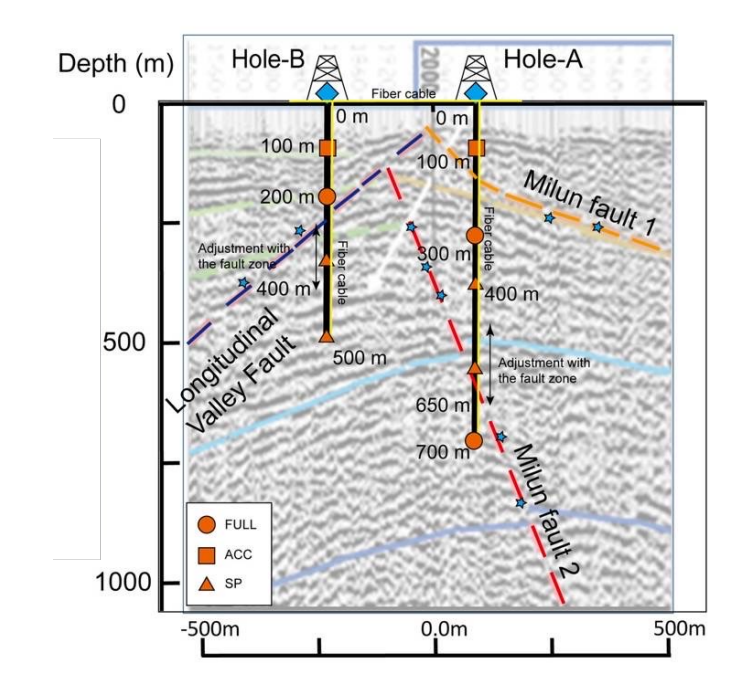

## Настройка sta/lta

Воспользуемся методом sta/lta чтобы обнаружить приход землетрясения. Запись ведётся в момент землетрясения в Турции 2023 года магнитудой 7.8

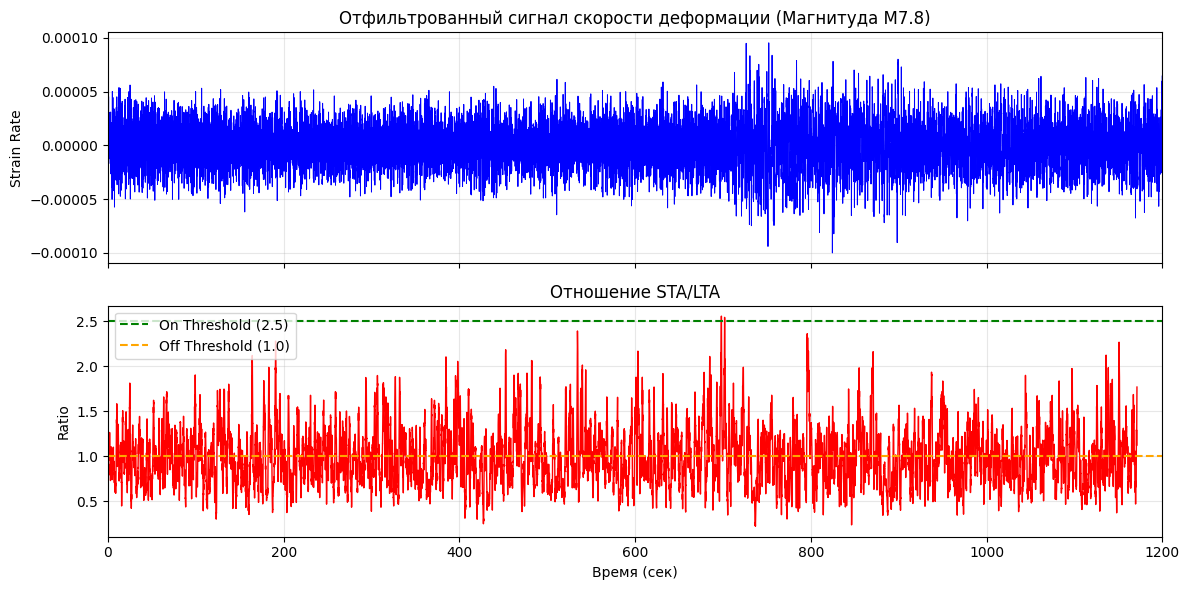

In [49]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from obspy import read

# 1. Настройки путей и параметров
# Убедитесь, что этот путь актуален для вашей системы
event_folder = '/mnt/c/Users/magam/OneDrive/Документы/das/Event_20230206011734_3600sec_M7.8/'
HOLE_A_RANGE = (1230, 1404)
# fs будет 100 Гц после децимации
fs = 100.0

def get_channel_files(folder, channel_range):
    all_files = glob.glob(os.path.join(folder, "*.mseed"))
    selected_files = []
    for f in all_files:
        try:
            # Извлекаем номер канала из начала имени файла (например, '00647.mseed' -> '00647')
            ch_num_str = os.path.basename(f).split('.')[0]
            ch_num = int(ch_num_str)
            if channel_range[0] <= ch_num <= channel_range[1]:
                selected_files.append(f)
        except (ValueError, IndexError):
            continue
    return sorted(selected_files)

def get_strain_rate_matrix(file_list, duration=1200, decimation=10):
    matrix = []
    f_sampling = 1000.0
    conversion_factor = 11.6e-9 * f_sampling
    
    for f in file_list[::2]: # Берем каждый 2-й канал
        st = read(f)
        tr = st[0]
        tr.trim(tr.stats.starttime, tr.stats.starttime + duration)
        tr.data = tr.data * conversion_factor
        tr.decimate(factor=decimation, strict_length=False)
        matrix.append(tr.data)
    
    return np.array(matrix)

def quick_filter(data, low, high, fs):
    nyq = 0.5 * fs
    b, a = butter(2, [low/nyq, high/nyq], btype='band')
    return filtfilt(b, a, data)

def classic_sta_lta(a, nsta, nlta):
    a = np.abs(a)
    ratio = np.full(a.shape, np.nan)
    if nlta >= len(a): return ratio
    sta = np.cumsum(np.insert(a, 0, 0))
    lta = np.cumsum(np.insert(a, 0, 0))
    diff = nlta - nsta
    sta_values = (sta[nsta:] - sta[:-nsta]) / nsta
    lta_values = (lta[nlta:] - lta[:-nlta]) / nlta
    lta_values[lta_values == 0] = np.finfo(float).eps
    ratio[nlta-diff:len(lta_values)+(nlta-diff)] = sta_values[diff:] / lta_values
    return ratio

def run_detection_pipeline(folder_path, channel_matrix_index=50, low_freq=0.1, high_freq=5.0, sta_sec=1, lta_sec=30, on_thresh=3.5, off_thresh=1.0):
    
    files_a = get_channel_files(folder_path, HOLE_A_RANGE)
    if not files_a:
        print(f"Ошибка: Файлы для скважины A не найдены в {folder_path}. Проверьте путь и формат имен файлов.")
        return

    # Загружаем данные в матрицу (уже обрезанные до 1200 сек и 100 Гц)
    data_a_matrix = get_strain_rate_matrix(files_a, duration=1200)
    
    # Выбираем конкретный канал из матрицы
    trace_data = data_a_matrix[channel_matrix_index]
    
    # Фильтруем (хотя decimate уже применил фильтр, мы наложим еще один)
    trace_filt = quick_filter(trace_data, low_freq, high_freq, fs=fs)
    
    # Расчет STA/LTA
    nsta = int(sta_sec * fs)
    nlta = int(lta_sec * fs)
    stalta_ratio = classic_sta_lta(trace_filt, nsta, nlta)
    
    # Визуализация (данные уже имеют длину 1200 сек)
    crop_sec = 1200
    time_axis = np.linspace(0, crop_sec, len(trace_filt))
    magnitude = folder_path.split('_')[-1].split('/')[0]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    ax1.plot(time_axis, trace_filt, lw=0.7, color='blue')
    ax1.set_title(f"Отфильтрованный сигнал скорости деформации (Магнитуда {magnitude})")
    ax1.set_ylabel("Strain Rate")
    ax1.grid(True, alpha=0.3)

    ax2.plot(time_axis, stalta_ratio, lw=1.0, color='red')
    ax2.axhline(on_thresh, color='green', linestyle='--', label=f'On Threshold ({on_thresh})')
    ax2.axhline(off_thresh, color='orange', linestyle='--', label=f'Off Threshold ({off_thresh})')
    ax2.set_title("Отношение STA/LTA")
    ax2.set_xlabel("Время (сек)")
    ax2.set_ylabel("Ratio")
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.set_xlim(0, crop_sec)
    plt.tight_layout()
    plt.show()

run_detection_pipeline(event_folder, on_thresh=2.5, off_thresh=1.0)


Видно что примерно перед пиком в отфильтрованных данных sta/lta пробивает порог в 2.5.

Порог был выбран вручную, чтобы не было ложных срабатываний.

Теперь попробуем воспользоваться этим же способом с заданным порогом для других землетрясений.

## Детектирование сигналов землетрясений с помощью sta/lta

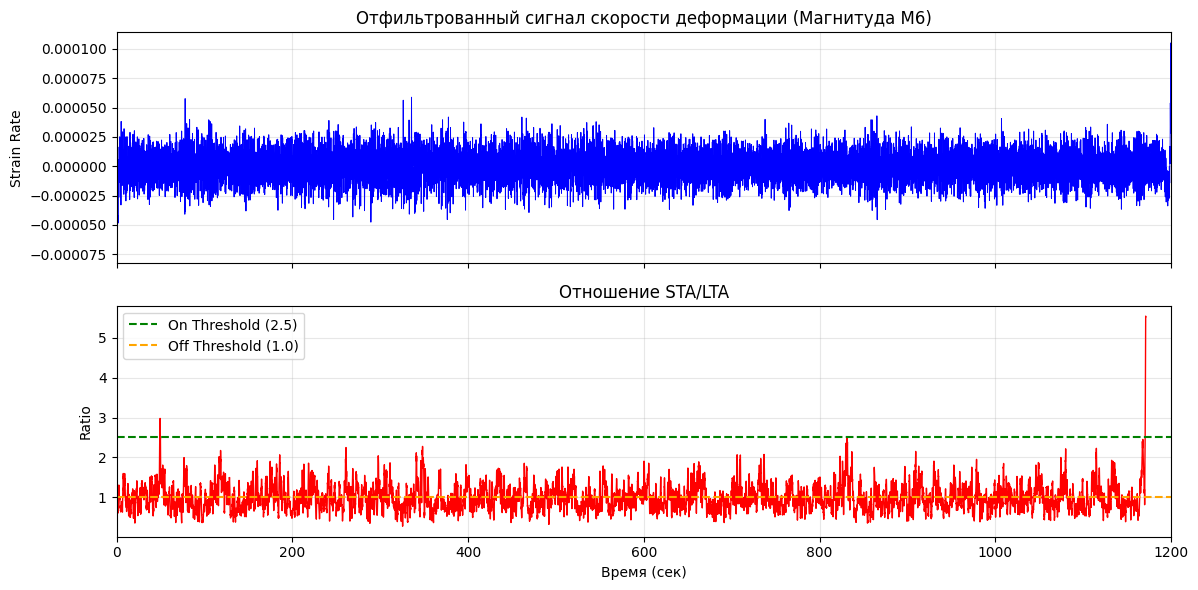

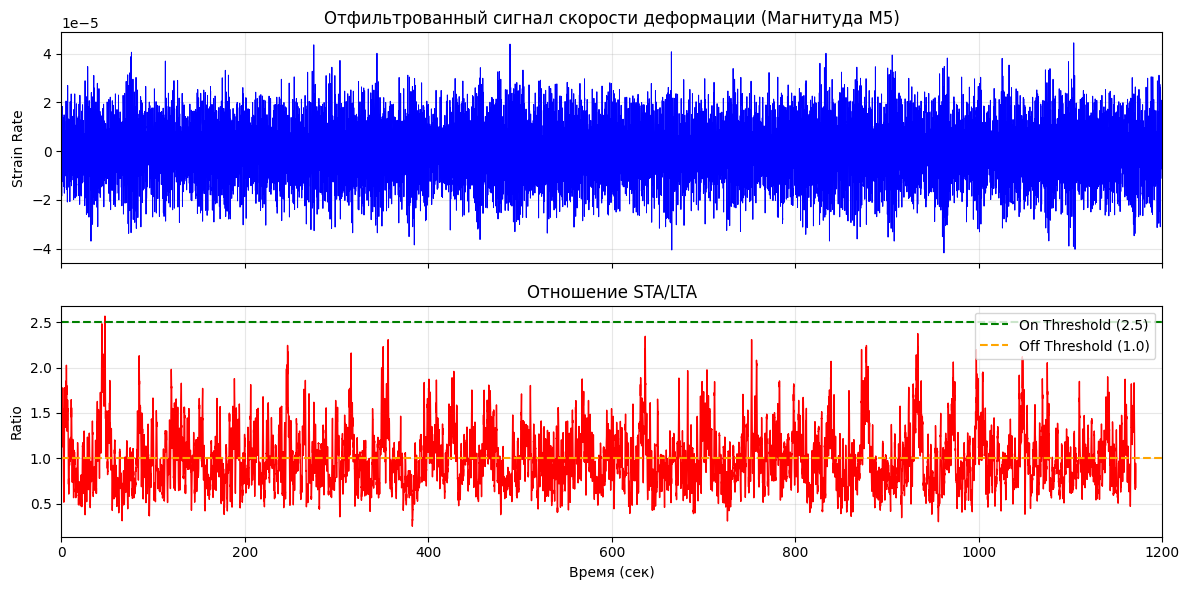

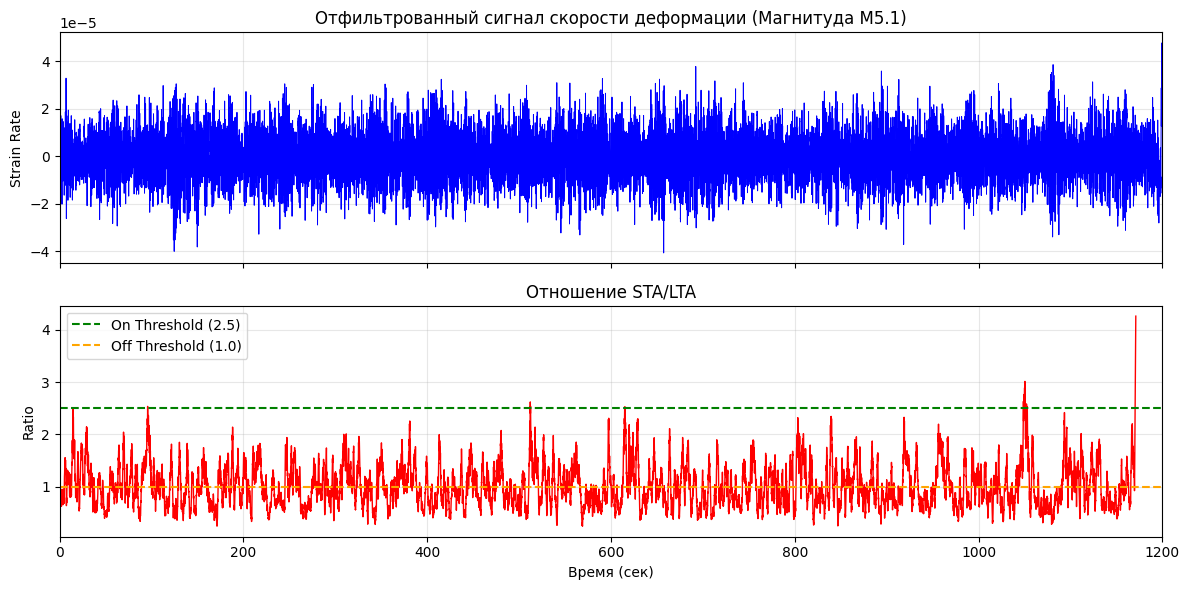

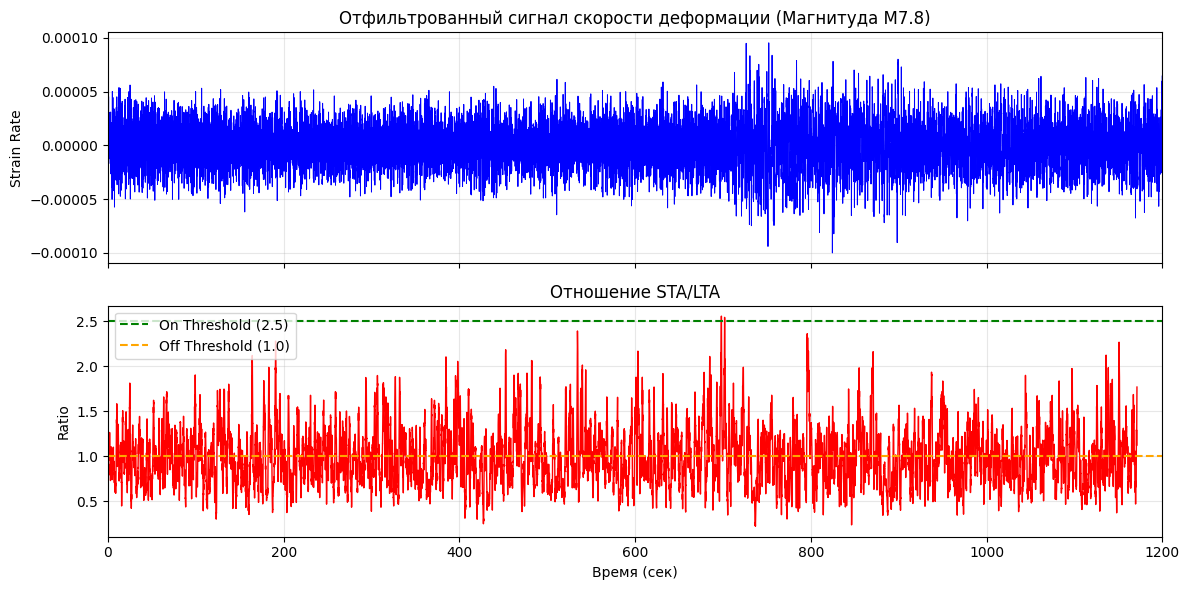

In [50]:
def process_all_event_folders(parent_dir):
    """Находит все поддиректории и запускает пайплайн для каждой."""
    # Получаем список всех элементов в директории
    for item in os.listdir(parent_dir):
        full_path = os.path.join(parent_dir, item)
        # Проверяем, является ли элемент директорией
        if os.path.isdir(full_path):
            # Запускаем наш пайплайн для этой папки
            run_detection_pipeline(full_path, on_thresh=2.5)

# --- Запуск всего процесса ---

# Укажите здесь путь к родительской папке, содержащей папки событий
# Например, если папка событий была '/mnt/c/Users/magam/OneDrive/Документы/das/Event_...', 
# то родительская папка будет '/mnt/c/Users/magam/OneDrive/Документы/das/'
parent_directory = '/mnt/c/Users/magam/OneDrive/Документы/das/' 

if os.path.exists(parent_directory):
    process_all_event_folders(parent_directory)
else:
    print(f"Ошибка: Родительская директория '{parent_directory}' не найдена.")
    sys.exit(1)

## Описание к графикам

1. Землетрясение магнитуды 6 проходило в 800 км от DAS. Ожидалось увеличение амплитуды показаний на 240 секунде, порог же пробивается в трёх местах не совпадающих с этим временем.

2. Землетрясение M5 в 15 500 км от Тайваня.

3. Землетрясение M5.1 в 17 000 км от Тайваня

4. Землетрясение M7.8 в Турции, 8500 км от Тайваня. 700 с - прибытие волны

## Выводы

Исходя из приведенных записей видно, что несмотря на то, что сигнал землетрясений может дойти до датчиков, как в случае с землетрясением из Турции(M7.8), детекция sta/lta ожидает значимого соотношения сигнала к шуму, недостаточного для обнаружения более слабых сигналов землетрясений.

Выбор гиперпараметров sta/lta так, чтобы точность детекции была максимальной, в условиях такого зашумления тоже является нетривиальной задачей.

В рамках предстоящей ВКР можно использовать более продвинутые техники шумподавления и детекции, используя как эвристические так и нейросетевые подходы.